# Using rf_functions module to compute rf buckets properties

In [1]:
# Adding folder on TOP of blond_common to PYTHONPATH
import sys
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
sys.path.append('./../../../')

## 0. Defining base ring and rf parameters

In [2]:
# Defining a constant energy
# Based on SPS with p+ at flat bottom with Q26 optics

from blond_common_fork.interfaces.beam.beam import Proton
from blond_common_fork.interfaces.input_parameters.ring import Ring

ring_length = 6911.5038                 # Machine circumference [m]
momentum = 25.92e9                      # Momentum [GeV/c]
gamma_transition = 22.77422954          # Transition gamma
alpha_0 = 1/gamma_transition**2.
particle = Proton()

ring = Ring(ring_length, alpha_0, momentum, particle)


In [3]:
# Defining the rf program
# The program is based on a batch compression and a rebucketting, the rf voltage at the three stages
# can be used for the example

from blond_common_fork.interfaces.input_parameters.rf_parameters import RFStation

harmonic = [4620]
voltage = [0.9e6]  # V, h21->h28 batch compression
phi_rf = [0]  # rad

rf_station = RFStation(ring, harmonic, voltage, phi_rf)


## 1. Computing the RF voltage and RF potential

In [4]:
# Computing the total rf voltage, using the parameters defined above
# The rf is computed on the limits defined by time_bounds

from blond_common_fork.rf_functions.potential import rf_voltage_generation

n_points = 1000
t_rev = ring.t_rev[0]
voltage = rf_station.voltage[:,0]
harmonic = rf_station.harmonic[:,0]
phi_rf = rf_station.phi_rf[:,0]
time_bounds = [-0.1*rf_station.t_rf[0,0], 1.1*rf_station.t_rf[0,0]]

time_array, rf_voltage_array = rf_voltage_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, time_bounds=time_bounds)


<IPython.core.display.Javascript object>


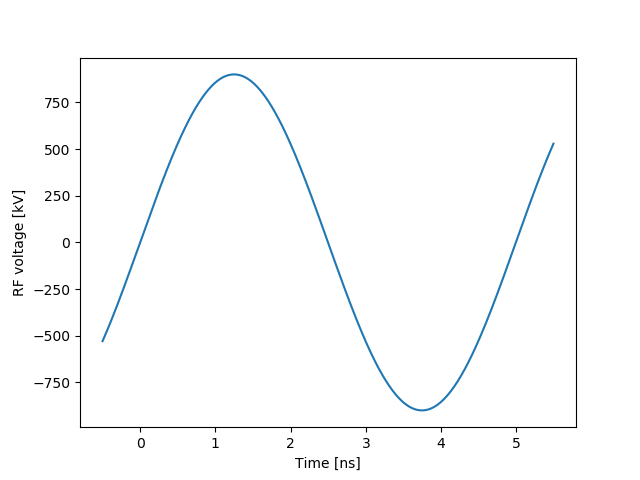

Text(0, 0.5, 'RF voltage [kV]')

In [5]:
# Plotting the total rf voltage
plt.figure('RF voltage')
plt.clf()
plt.plot(time_array*1e9, rf_voltage_array/1e3)
plt.xlabel('Time [ns]')
plt.ylabel('RF voltage [kV]')

In [6]:
# The rf potential can be calculated analytically

from blond_common_fork.rf_functions.potential import rf_potential_generation

n_points = 1000
eta_0 = ring.eta_0[0,0]
charge = ring.Particle.charge
energy_increment = ring.delta_E[0]

time_array, rf_potential_array = rf_potential_generation(
    n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment,
    time_bounds=time_bounds)

<IPython.core.display.Javascript object>


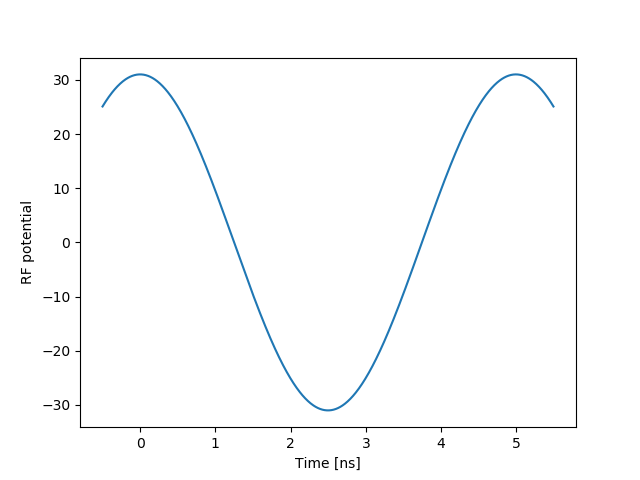

Text(0, 0.5, 'RF potential')

In [7]:
# Plotting the rf potential
plt.figure('Potential well')
plt.clf()
plt.plot(time_array*1e9, rf_potential_array)
plt.xlabel('Time [ns]')
plt.ylabel('RF potential')

## 2. Find potential wells

In [8]:
# The potential wells can be obtained using find_potential_wells_cubic (cubic spline interpolation)
# This returns the maxima locations and values, the minima locations and values, as well as the
# highest inner maximum if an inner bucket is detected

from blond_common_fork.rf_functions.potential import find_potential_wells_cubic

(potwell_max_locs, potwell_max_vals,
 potwell_inner_max, potwell_min_locs,
 potwell_min_vals) = find_potential_wells_cubic(
    time_array, rf_potential_array)

<IPython.core.display.Javascript object>


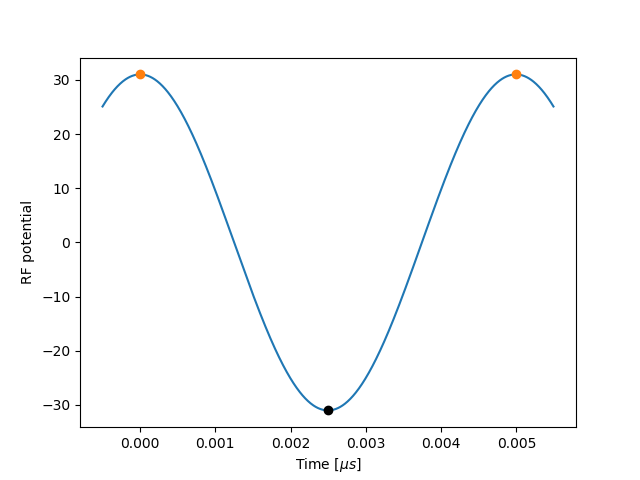

Text(0, 0.5, 'RF potential')

In [9]:
# Plotting the detected rf potential wells

plt.figure('Potential well -3')
plt.clf()
plt.plot(time_array*1e6, rf_potential_array)
for index_pot in range(len(potwell_max_locs)):
    plt.plot(np.array(potwell_max_locs)[index_pot]*1e6,
             np.array(potwell_max_vals)[index_pot], 'o')
plt.plot(np.array(potwell_min_locs)*1e6, potwell_min_vals, 'ko')
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

## 3. Cut potential wells to get separatrices, acceptance

In [10]:
# Once the potential wells are detected, the potential_well_cut can be used to return
# lists containing all the potential wells and their corresponding time array

from blond_common_fork.rf_functions.potential import potential_well_cut_cubic

time_array_list, potential_well_list = potential_well_cut_cubic(
    time_array, rf_potential_array, potwell_max_locs)


<IPython.core.display.Javascript object>


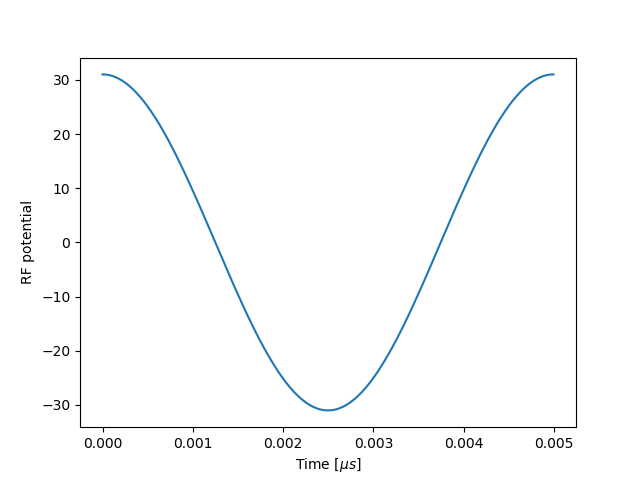

Text(0, 0.5, 'RF potential')

In [11]:
# Plotting the cut potential wells

plt.figure('Potential well cut')
plt.clf()
for index_pot in range(len(time_array_list)):
    plt.plot(time_array_list[index_pot]*1e6, potential_well_list[index_pot])
plt.xlabel('Time [$\\mu s$]')
plt.ylabel('RF potential')

In [12]:
# The trajectory defined by the potential well (i.e. the separatrices) can be obtained with trajectory_area
# This also returns the enclosed area (i.e. the acceptance) and the half height in E of the trajectory

from blond_common_fork.rf_functions.potential import trajectory_area_cubic

eta_0 = ring.eta_0[0,0]
beta_rel = ring.beta[0,0]
tot_energy = ring.energy[0,0]

dEtraj_list = []  # The trajectories at the edge of the pot. well
calc_area_list = []  # The enclosed areas

for index_pot in range(len(time_array_list)):
    (time_array, dEtraj, hamiltonian, calc_area,
     half_energy_height, full_length_time) = trajectory_area_cubic(
        time_array_list[index_pot], potential_well_list[index_pot],
        eta_0, beta_rel, tot_energy)
    dEtraj_list.append(dEtraj)
    calc_area_list.append(calc_area)


C:\Work\git\blond_common_fork\rf_functions\potential.py:419: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)


<IPython.core.display.Javascript object>


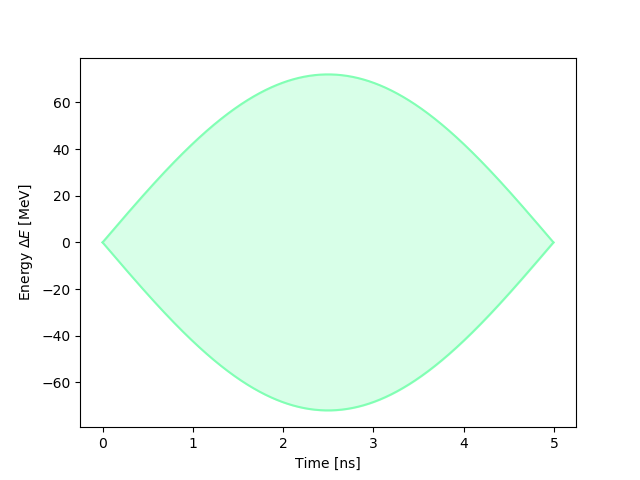

In [13]:
plt.figure('Separatrices')
plt.clf()
colors = plt.cm.rainbow(np.interp(calc_area_list,
                             [0.9*np.min(calc_area_list), 1.1*np.max(calc_area_list)],
                             [0, 1]))
for index_pot in range(len(time_array_list)):
    plt.plot(time_array_list[index_pot]*1e9, dEtraj_list[index_pot]/1e6, color=colors[index_pot])
    plt.plot(time_array_list[index_pot]*1e9, -dEtraj_list[index_pot]/1e6, color=colors[index_pot])
    plt.fill_between(time_array_list[index_pot]*1e9, dEtraj_list[index_pot]/1e6,
                     -dEtraj_list[index_pot]/1e6, color=colors[index_pot],
                     alpha=0.3)
    plt.xlabel('Time [ns]')
    plt.ylabel('Energy $\\Delta E$ [MeV]')

## 4. Get the action as a emittance of the hamiltonian

In [14]:
from blond_common_fork.rf_functions.potential import area_vs_hamiltonian_cubic

eta_0 = ring.eta_0[0,0]
beta_rel = ring.beta[0,0]
tot_energy = ring.energy[0,0]

index_pot = 0

(time_array_ham, hamiltonian_scan, \
    calc_area_scan, half_energy_height_scan, \
    full_length_time_scan) = area_vs_hamiltonian_cubic(
    time_array_list[index_pot], potential_well_list[index_pot],
    eta_0, beta_rel, tot_energy, n_points_reinterp=100,
    inner_max_potential_well=potwell_inner_max[index_pot])

<IPython.core.display.Javascript object>


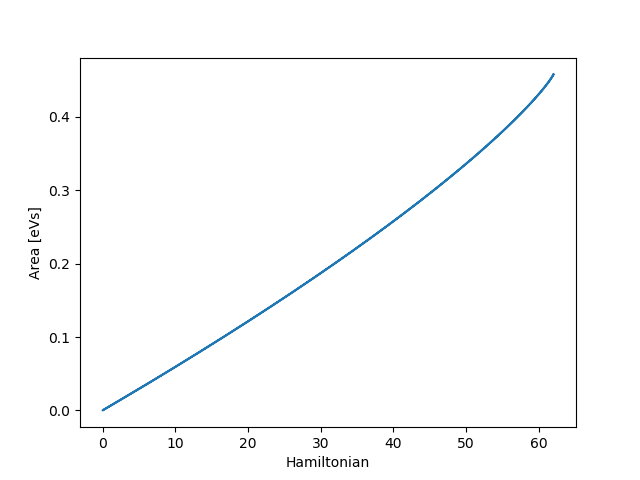

Text(0, 0.5, 'Area [eVs]')

In [15]:
plt.figure('Area vs. hamiltonian')
plt.plot(hamiltonian_scan[1:], calc_area_scan[1:])
plt.xlabel('Hamiltonian')
plt.ylabel('Area [eVs]')

## 5. Compute synchrotron frequency vs. amplitude

In [16]:
from blond_common_fork.rf_functions.potential import synchrotron_frequency_cubic
from blond_common_fork.maths.calculus import deriv_cubic
from scipy.special import ellipk

sort_area = np.argsort(calc_area_scan)
fs_cubic_manual = deriv_cubic(calc_area_scan[sort_area],
                       hamiltonian_scan[sort_area])[1]/(2*np.pi)

(time_array_fs, fs_cubic, hamiltonian_scan,
 calc_area_scan, half_energy_height_scan,
 full_length_time_scan) = synchrotron_frequency_cubic(
    time_array_list[index_pot], potential_well_list[index_pot],
    eta_0, beta_rel, tot_energy, n_points_reinterp=None,  # 100, 1000
    inner_max_potential_well=potwell_inner_max[index_pot])

fs_approx = rf_station.omega_s0[0]/(2*np.pi)*(
    1-(rf_station.omega_rf[0,0]*(
        time_array_fs-rf_station.t_rf[0,0]/2))**2./16)
fs_exact = rf_station.omega_s0[0]/(2*np.pi)*np.pi/(2*ellipk(np.sin(rf_station.omega_rf[0,0]*(
        time_array_fs-rf_station.t_rf[0,0]/2)/2)**2.))

<IPython.core.display.Javascript object>


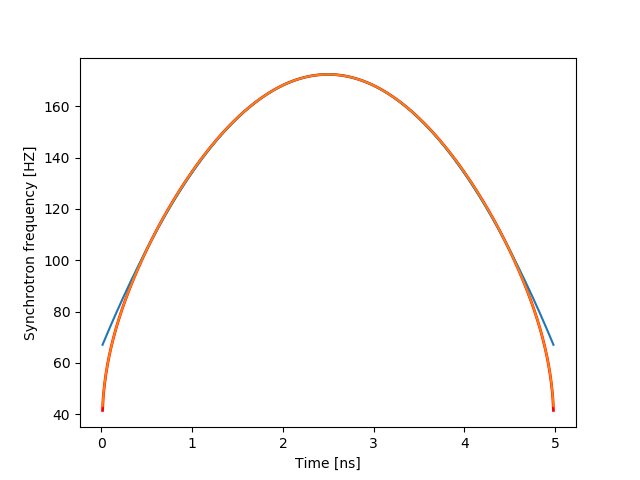

Text(0, 0.5, 'Synchrotron frequency [HZ]')

In [17]:
plt.figure('Sync freq')
plt.clf()
plt.plot(time_array_fs*1e9, fs_cubic, 'r', linewidth=2)
plt.plot(time_array_fs*1e9, fs_approx)
plt.plot(time_array_fs*1e9, fs_exact)
plt.xlabel('Time [ns]')
plt.ylabel('Synchrotron frequency [HZ]')

<IPython.core.display.Javascript object>


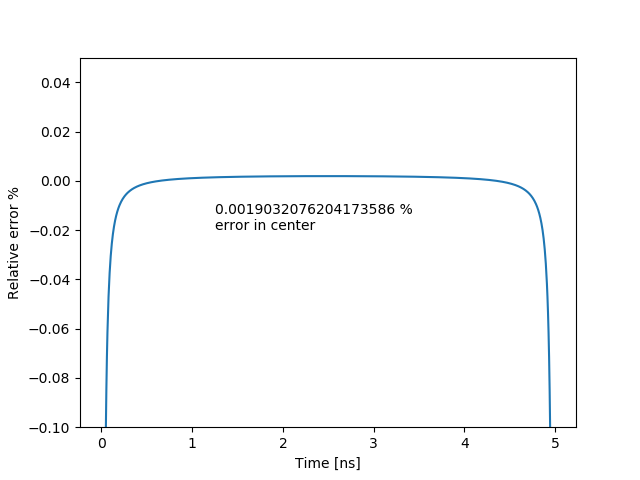

Text(0, 0.5, 'Relative error %')

In [18]:
# Plotting the relative error with respect to exact solution
plt.figure('Sync freq diff')
plt.clf()
plt.plot(time_array_fs*1e9, (fs_cubic-fs_exact)/fs_exact*100)
plt.ylim((-100e-5*100, 5e-4*100))
plt.text(rf_station.t_rf[0,0]/4*1e9, -20e-5*100,
         str(np.max((fs_cubic-fs_exact)/fs_exact*100))+' % \nerror in center')
plt.xlabel('Time [ns]')
plt.ylabel('Relative error %')